In [42]:
import ot as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import itertools
import ot as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.optimize import linprog
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value, PULP_CBC_CMD
from gurobipy import Model, GRB, quicksum

In [43]:
data = pd.read_stata('JPSAERdata.dta')# Assuming 'data' is your DataFrame

# Filter data for 'sample' == 1
sample_data = data[data['sample'] == 1]

# Create dummy variables for 'yymm'
yymm_dummies = pd.get_dummies(sample_data['yymm'], prefix='yymm')

# Convert dummy variable column names to strings
yymm_dummies.columns = yymm_dummies.columns.astype(str)

# Prepare the dataset for regression
reg_data = pd.concat([sample_data, yymm_dummies], axis=1)
# reg_data.dropna(subset=['income'], inplace=True)
#reg_data.dropna(subset=['liqassii'], inplace=True)

# Assuming 'reg_data' is your DataFrame prepared for regression


reg_data['age_squared'] = reg_data['age']**2
# Assuming filteredData is a pandas DataFrame

# Min-Max Normalization for 'income'
reg_data['income_min_max'] = reg_data['income'].apply(
    lambda x: (x - reg_data['income'].min()) / (reg_data['income'].max() - reg_data['income'].min())
)


# Min-Max Normalization for 'age'
reg_data['age_min_max'] = reg_data['age'].apply(
    lambda x: (x - reg_data['age'].min()) / (reg_data['age'].max() - reg_data['age'].min())
)

# Min-Max Normalization for 'age'
reg_data['liqassii_min_max'] = reg_data['liqassii'].apply(
    lambda x: (x - reg_data['liqassii'].min()) / (reg_data['liqassii'].max() - reg_data['liqassii'].min())
)

# Min-Max Normalization for 'age'
reg_data['age_squared_min_max'] = reg_data['age_squared'].apply(
    lambda x: (x - reg_data['age_squared'].min()) / (reg_data['age_squared'].max() - reg_data['age_squared'].min())
)
reg_data['taxreb_0'] = 0
reg_data['taxreb_300'] = 300
reg_data['taxreb_600'] = 600
reg_data['taxreb_1000'] = 1000


In [44]:
subset = 'standard'
tax_reb_num = 1000

In [45]:
synthetic_params = pd.read_csv('IVQR_dcn.csv',header=None)
# Assuming reg_data is your DataFrame and is already defined
# Exogenous variables, excluding the endogenous variable 'income' if it's being instrumented
if subset == 'standard':
    reg_data_exog= reg_data
    reg_data_pre = reg_data
elif subset == 'age_young':
    reg_data_exog= reg_data[(reg_data['taxreb']==tax_reb_num)  & (reg_data['age'] <= 39)]
    reg_data_pre = reg_data[(reg_data['taxreb']==0 )   & (reg_data['age'] <= 39)]
elif subset == 'age_old':
    reg_data_exog= reg_data[(reg_data['taxreb']==tax_reb_num)  & (reg_data['age'] >= 58)]
    reg_data_pre = reg_data[(reg_data['taxreb']==0 )   & (reg_data['age'] >= 58)]
elif subset == 'income_low':
    reg_data_exog= reg_data[(reg_data['taxreb']==tax_reb_num) & (reg_data['income'] <=34928)]
    reg_data_pre = reg_data[(reg_data['taxreb']==0 )  & (reg_data['income'] <=34928)]
elif subset == 'income_high':
    reg_data_exog= reg_data[(reg_data['taxreb']==tax_reb_num) & (reg_data['income'] > 69000)]
    reg_data_pre = reg_data[(reg_data['taxreb']==0 )  & (reg_data['income'] > 69000)]
elif subset == 'liquid_low':
    reg_data_exog= reg_data[(reg_data['taxreb']==tax_reb_num) & (reg_data['liqassii'] <= 1000)]
    reg_data_pre = reg_data[(reg_data['taxreb']==0)   & (reg_data['liqassii'] <= 1000)] 
elif subset == 'liquid_high':
    reg_data_exog= reg_data[(reg_data['taxreb']==tax_reb_num) & (reg_data['liqassii'] > 8000)]
    reg_data_pre = reg_data[(reg_data['taxreb']==0)   & (reg_data['liqassii'] > 8000)] 



exog = reg_data_exog[[f'taxreb_{tax_reb_num}','age_min_max','dnumadult',
    'dnumkids' , 'yymm_10102', 'yymm_10103', 'yymm_10104', 'yymm_10105', 'yymm_10106', 'yymm_10107',
                 'yymm_10108', 'yymm_10109', 'yymm_10110', 'yymm_10111', 'yymm_10112',
                 'yymm_10201', 'yymm_10202', 'yymm_10203'
                 ]]
exog_pre = reg_data_pre[['taxreb_0','age_min_max', 'dnumadult',
    'dnumkids' , 'yymm_10102', 'yymm_10103', 'yymm_10104', 'yymm_10105', 'yymm_10106', 'yymm_10107',
                 'yymm_10108', 'yymm_10109', 'yymm_10110', 'yymm_10111', 'yymm_10112',
                 'yymm_10201', 'yymm_10202', 'yymm_10203'
                 ]]


In [46]:
sp_np= synthetic_params.to_numpy()
exog_np = exog.to_numpy()
synthetic_data=exog_np@sp_np
synthetic_data_reshaped = synthetic_data.reshape(1, -1)

In [47]:
exog_pre_np = exog_pre.to_numpy()
synthetic_data_pre = exog_pre_np@sp_np

In [58]:
post_predictions = np.random.choice( synthetic_data_reshaped.flatten(), size=700, replace=True) 
pre_predictions = np.random.choice( synthetic_data_pre.flatten(), size=700, replace=True) 
#pre_data = reg_data[(reg_data['itotalreb'] ==0)]
#pre_predictions = pre_data['dcn']

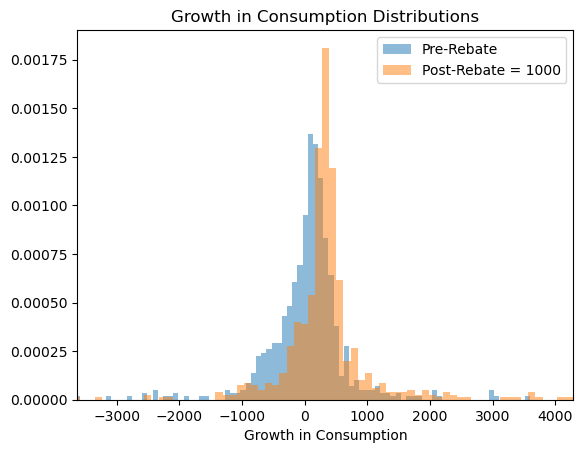

In [59]:
plt.hist(pre_predictions, bins = 200, alpha=0.5, density=True)
plt.hist(post_predictions, bins = 200, alpha=0.5, density=True)

# Calculate the 1st and 99th percentiles to use as xlim values
lower_bound, upper_bound = np.percentile(post_predictions, [1, 99])

# Set the x-axis limits to exclude extreme outliers
plt.xlim(lower_bound, upper_bound)
plt.title('Growth in Consumption Distributions')
plt.legend(['Pre-Rebate', f'Post-Rebate = {tax_reb_num}'])
plt.xlabel('Growth in Consumption')
plt.show()



In [60]:
treated   = post_predictions
untreated = pre_predictions
xs = untreated
xt = treated
xs_reshaped = xs.reshape(-1)
xt_reshaped = xt.reshape(-1)

kde_xs = gaussian_kde(xs)
kde_xt = gaussian_kde(xt)



In [61]:
def compute_constraint_problem(l, k, type, bound_type, xs_reshaped_500, xt_reshaped_500, kde_xs_500, kde_xt_500, penalty = 1e9):
    # Calculate pairwise cityblock (Manhattan) distances
    Mp = np.abs(xs_reshaped_500[:, None] - xt_reshaped_500[None, :])

    # Cost matrix without additional constraint
    if bound_type == "lower":
        M = (Mp > k).astype(float)
    elif bound_type == "upper":
        M = (Mp < k).astype(float)
    # Precompute KDE weights
    weights_xs = kde_xs_500(xs_reshaped_500) / np.sum(kde_xs_500(xs_reshaped_500))
    weights_xt = kde_xt_500(xt_reshaped_500) / np.sum(kde_xt_500(xt_reshaped_500))

    # Flatten the weights for the linear programming solver
    weights_xs_flat = weights_xs.flatten()
    weights_xt_flat = weights_xt.flatten()

    # Number of variables
    n = len(weights_xs_flat)
    # Create the Gurobi model
    model = Model("WassersteinDistance")
    model.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Create variables for the transport plan
    T_vars = model.addVars(n, n, lb=0, ub=1, name="T")

    # Objective function
    objective = quicksum(T_vars[i, j] * M[i, j] for i in range(n) for j in range(n))

    # Add penalty terms for constraint violations
    for i in range(n):
        for j in range(n):
            if type == "card":
                if xt_reshaped_500[j] - xs_reshaped_500[i] > 1500:
                    objective += penalty * T_vars[i, j]
            elif type == "mono":
                if xs_reshaped_500[i] > xt_reshaped_500[j]:
                    objective += penalty * T_vars[i, j]
            elif type == "both":
                if xs_reshaped_500[i] > xt_reshaped_500[j] or xt_reshaped_500[j] - xs_reshaped_500[i] > 1500:
                    objective += penalty * T_vars[i, j]

    model.setObjective(objective, GRB.MINIMIZE)

    # Add row constraints
    for i in range(n):
        model.addConstr(quicksum(T_vars[i, j] for j in range(n)) == weights_xs_flat[i])

    # Add column constraints
    for j in range(n):
        model.addConstr(quicksum(T_vars[i, j] for i in range(n)) == weights_xt_flat[j])

    # Optimize the model
    model.optimize()

    # Check if the model solved correctly
    if model.status == GRB.OPTIMAL:
        # Calculate the objective value without penalty
        objective_no_penalty = sum(T_vars[i, j].X * M[i, j] for i in range(n) for j in range(n))
        return objective_no_penalty
    else:
        print(f"Model did not solve to optimality at iteration {l + 1}. Status: {model.status}")
        return None

In [62]:
d_vector_lower = np.linspace(0.5, 1000, 100)


In [53]:
import numpy as np
from gurobipy import Model, GRB, quicksum
from joblib import Parallel, delayed

# Initialize the array to store Wasserstein distances
W_statistic_lower_min_both = np.zeros(len(d_vector_lower))



penalty = 1e9


# Use parallel processing to speed up the loop
results = Parallel(n_jobs=-1)(delayed(compute_constraint_problem)(l, k, 'both', 'lower', xs_reshaped, xt_reshaped, kde_xs, kde_xt, penalty = 1e9) for l, k in enumerate(d_vector_lower))

# Store results
for l, result in enumerate(results):
    if result is not None:
        W_statistic_lower_min_both[l] = result


Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-18
Academic license - for non-commercial use only - expires 2025-02-18
Academic license - for non-commercial use only - expires 2025-02-18
Academic license - for non-commercial use only - expires 2025-02-18
Academic license - for non-commercial use only - expires 2025-02-18
Academic license - for non-commercial use only - expires 2025-02-18
Academic license - for non-commercial use only - expires 2025-02-18
Academic license - for non-commercial use only - expires 2025-02-18
Academic license - for non-commercial use only - expires 2025-02-18
Academic license - f

In [54]:
import numpy as np
from gurobipy import Model, GRB, quicksum
from joblib import Parallel, delayed

# Initialize the array to store Wasserstein distances
W_statistic_lower_max_both = np.zeros(len(d_vector_lower))



penalty = 1e9


# Use parallel processing to speed up the loop
results = Parallel(n_jobs=-1)(delayed(compute_constraint_problem)(l, k, 'both', 'upper', xs_reshaped, xt_reshaped, kde_xs, kde_xt, penalty = 1e9) for l, k in enumerate(d_vector_lower))

# Store results
for l, result in enumerate(results):
    if result is not None:
        W_statistic_lower_max_both[l] = result

In [55]:
W_statistic_lower_max = np.zeros(len(d_vector_lower))
j = 0
for i in d_vector_lower: 
    Mp = ot.dist(xs_reshaped[:, None], xt_reshaped[:, None], metric='cityblock')
    M = Mp > i
    M = -1*M
    # Calculate weights for distributions using KDE
    weights_xs = kde_xs(xs_reshaped) / np.sum(kde_xs(xs_reshaped))
    weights_xt = kde_xt(xt_reshaped) / np.sum(kde_xt(xt_reshaped))

    # Wasserstein distance calculation using emd2
    W = ot.emd2(weights_xs, weights_xt, M, numItermax=1000000)
    W_statistic_lower_max[j] = W
    j = j+1 

In [56]:
W_statistic_lower_min = np.zeros(len(d_vector_lower))
j = 0
for i in d_vector_lower: 
    Mp = ot.dist(xs_reshaped[:, None], xt_reshaped[:, None], metric='cityblock')
    M = Mp > i

    # Calculate weights for distributions using KDE
    weights_xs = kde_xs(xs_reshaped) / np.sum(kde_xs(xs_reshaped))
    weights_xt = kde_xt(xt_reshaped) / np.sum(kde_xt(xt_reshaped))

    # Wasserstein distance calculation using emd2
    W = ot.emd2(weights_xs, weights_xt, M, numItermax=1000000)
    W_statistic_lower_min[j] = W
    j = j+1  


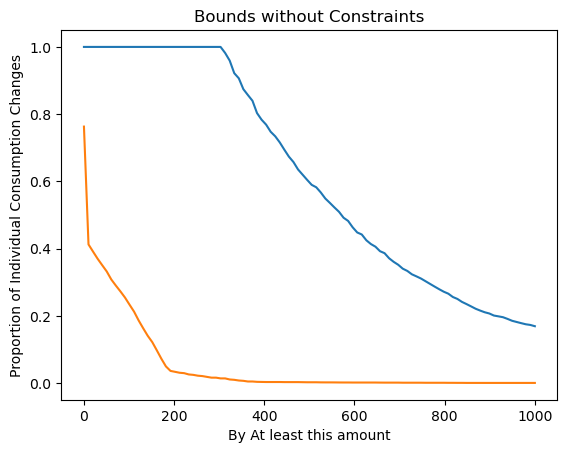

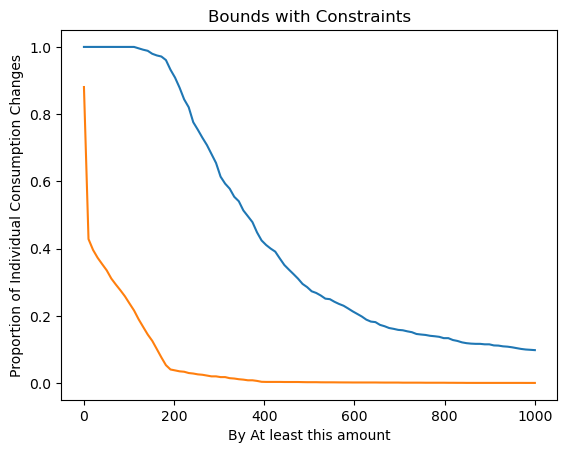

In [57]:
plt.plot(d_vector_lower, -W_statistic_lower_max)
plt.plot(d_vector_lower, W_statistic_lower_min)
plt.title('Bounds without Constraints')
plt.ylabel('Proportion of Individual Consumption Changes')
plt.xlabel('By At least this amount')
plt.show()

plt.plot(d_vector_lower, 1-W_statistic_lower_max_both)
plt.plot(d_vector_lower, W_statistic_lower_min_both)
plt.title('Bounds with Constraints')
plt.ylabel('Proportion of Individual Consumption Changes')
plt.xlabel('By At least this amount')
plt.show()